## 1. 데이터 불러오기

In [73]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [74]:
file_path = './dataset/'
train_fn = 'FordA_TRAIN.arff'
test_fn = 'FordA_TEST.arff'

def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])

    for i, col in zip(range(len(cols)), cols):
        data2d[:, i]=raw_data[col]
    return data2d

train =  read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

In [75]:
print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [76]:
x_train_temp = train[:,:-1]
y_train_temp = train[:,-1]

x_test = test[:, :-1]
y_test = test[:, -1]

In [77]:
normal_x = x_train_temp[y_train_temp==1]
abnormal_x = x_train_temp[y_train_temp==-1]
normal_y = y_train_temp[y_train_temp==1]
abnormal_y = y_train_temp[y_train_temp==-1]

x_train_normal, x_valid_normal, y_train_normal, y_valid_normal = train_test_split(
    normal_x, normal_y, test_size=0.2, random_state=42, stratify=normal_y)

x_train_abnormal, x_valid_abnormal, y_train_abnormal, y_valid_abnormal = train_test_split(
    abnormal_x, abnormal_y, test_size=0.2, random_state=42, stratify=abnormal_y)

x_train = np.concatenate((x_train_normal, x_train_abnormal), axis=0)
y_train = np.concatenate((y_train_normal, y_train_abnormal), axis=0)

x_valid = np.concatenate((x_valid_normal, x_valid_abnormal), axis=0)
y_valid = np.concatenate((y_valid_normal, y_valid_abnormal), axis=0)

In [78]:
print('x_train.shape:', x_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_valid.shape:', y_valid.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (2880, 500)
x_valid.shape: (721, 500)
y_train.shape: (2880,)
y_valid.shape: (721,)
x_test.shape: (1320, 500)
y_test.shape: (1320,)


## 2.데이터 전처리

#### 2.1 데이터 정규화

- 동일 시간 길이(3,600) 내 센서 값들이 넓은 범위로 퍼져있다.

- 변수 간의 Scale이 서로 다르기 때문에, 데이터를 그대로 학습하는 것은 적절하지 않다.

- 인풋 값들을 정규화(Normalization)을 한다.

- 흔히 공정 데이터에는 이상치(Outlier)가 발생할 수 있는데 강건한 정규화가 필요할 때 RobustScaler를 사용한다.

- StandScaler는 보다 더 일반적으로 사용하는 정규화 방법

    - 데이터를 단위 분산으로 조정함으로써 Outlier에 취약할 수 있음     

- RobustScaler는 Feature간 스케일을 갖게 되지만 평균과 분산 대신 중간 값(median)과 사분위값(quartile)을 사용 -> 극단값(Outlier)에 영향을 받지 않음

In [79]:
print("x_train shape:", x_train.shape)  # (num_samples, num_features)
print("x_valid shape:", x_valid.shape)  # (num_samples, num_features)

x_train shape: (2880, 500)
x_valid shape: (721, 500)


In [80]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stder = StandardScaler()
stder.fit(x_train)
x_train = stder.transform(x_train)
x_valid = stder.transform(x_valid)

# rscaler = RobustScaler()
# rscaler.fit(x_train)
# x_train = rscaler.transform(x_train)
# x_valid = rscaler.transform(x_valid)

#### 2.2 데이터 형태 변환


In [81]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

## 3.지표 함수

##### (1) Confustion Matrix

In [82]:
def draw_confusion_matrix(model, xt, yt, model_name):
    y_pred = model.predict(xt)
    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max() / 2
    fmt = 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(classification_report(yt, y_pred))

##### (2) ROC Curve

In [119]:
def draw_roc(model, xt, yt, model_name):
    # numpy로 구현한 모델인 경우
    if not hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_prob(xt)
    else:
        # sklearn 모델인 경우
        y_pred_proba = model.predict_proba(xt)[:, 1]
        
    fpr, tpr, _ = roc_curve(yt, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (3) Epoch에 따른 학습 & 검증의 손실(loss) 그래프


In [84]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.ylabel('loss', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (4) Epoch에 따른 정확도(Accuracy Rate) 그래프

In [85]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val'+'sparse_categorical_accuracy'])
    plt.title('model'+'Prediction Accuracy')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

## 4. 모델 구축 및 설계

#### 4.1 Logistic Regression

##### (1) scikit-learn

In [86]:
# clf_lr_1 = LogisticRegression(penalty='l2',
#                               tol=0.0001,
#                               C=1,
#                               fit_intercept=True,
#                               intercept_scaling=1,
#                               random_state=2,
#                               solver='lbfgs',
#                               max_iter=1000,
#                               multi_class='auto') 

In [87]:
# x_train_lr = np.concatenate((x_train, x_valid), axis=0)
# y_train_lr = np.concatenate((y_train, y_valid), axis=0)

In [134]:
# clf_lr_1.fit(x_train_lr, y_train_lr)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, multi_class='auto', random_state=2)

In [89]:
# y_pred = clf_lr_1.predict(x_test)
# score = clf_lr_1.score(x_test, y_test)
# print('%s: %.4f%%' % ('Logistic Regression Prediction Rate', score*100))

Logistic Regression Prediction Rate: 49.0152%


In [128]:
# from sklearn.metrics import f1_score

# y_pred = clf_lr_1.predict(x_test)
# f1 = f1_score(y_test, y_pred)

# print("F1 Score (sklearn):", f1)

F1 Score (sklearn): 0.44971381847914965


In [90]:
# # Performance metrics
# print("Accuracy: ", accuracy_score(y_test, y_pred))
# print("AUC Score: ", roc_auc_score(y_test, clf_lr_1.predict_proba(x_test)[:, 1]))

Accuracy:  0.49015151515151517
AUC Score:  0.4851858745883688


##### (2) Numpy

In [91]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=1000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.eps = 1e-10
        self.threshold = 0.5
        self.loss_history = list()

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return(-y * np.log(h + self.eps) - (1 - y) * np.log(1 - h + self.eps)).mean() 
    
    # 학습데이터로 model을 학습하는 메서드
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

            # weights initialization
            self.theta = np.zeros(X.shape[1])

            for i in range(self.num_iter):
                logit = np.dot(X, self.theta)
                hypothesis = self.__sigmoid(logit)
                gradient = np.dot(X.T, (hypothesis - y)) / y.size
                self.theta -= self.lr * gradient

                if self.verbose == True and i % 10 == 0:
                    loss = self.__loss(hypothesis, y)
                    print(f'epoch: {i} \t loss: {loss} \t')
                    self.loss_history.append(loss)
            return self.loss_history

    # 학습데이터로 학습된 model을 바탕으로 테스트데이터의 Label을 확인하는 메서드    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        predicted_labels = np.where(self.predict_prob(X)> self.threshold, 1, 0)
        return predicted_labels
    
    # 모델의 테스트 정확도 도출
    def eval(self, x, y):
        res_y = np.round(self.predict_prob(x), 0)
        accuracy = np.sum(res_y==y)/len(y)
        return accuracy


In [92]:
clf_lr_2 = LogisticRegression(lr=0.01, num_iter=1000, verbose=True)
history_lr = clf_lr_2.fit(x_train_lr, y_train_lr)

epoch: 0 	 loss: 0.6931471803599453 	
epoch: 10 	 loss: 0.6904875992104353 	
epoch: 20 	 loss: 0.6889149696333092 	
epoch: 30 	 loss: 0.6877613977712428 	
epoch: 40 	 loss: 0.6868486595583806 	
epoch: 50 	 loss: 0.6861023103093608 	
epoch: 60 	 loss: 0.685479610670181 	
epoch: 70 	 loss: 0.6849519954113849 	
epoch: 80 	 loss: 0.6844990524825462 	
epoch: 90 	 loss: 0.6841056875212047 	
epoch: 100 	 loss: 0.6837604945134884 	
epoch: 110 	 loss: 0.6834547162780263 	
epoch: 120 	 loss: 0.6831815423893483 	
epoch: 130 	 loss: 0.6829356178979483 	
epoch: 140 	 loss: 0.682712690887489 	
epoch: 150 	 loss: 0.682509354806311 	
epoch: 160 	 loss: 0.6823228572320889 	
epoch: 170 	 loss: 0.6821509561785474 	
epoch: 180 	 loss: 0.6819918109993922 	
epoch: 190 	 loss: 0.6818438988198187 	
epoch: 200 	 loss: 0.6817059500237241 	
epoch: 210 	 loss: 0.6815768981072029 	
epoch: 220 	 loss: 0.6814558404560175 	
epoch: 230 	 loss: 0.6813420074919269 	
epoch: 240 	 loss: 0.6812347382729245 	
epoch: 250 	 l

In [126]:
score = clf_lr_2.eval(x_test, y_test)
print('%s: %.4f%%' % ('Logistic Regression Prediction Rate', score*100))

Logistic Regression Prediction Rate: 49.1667%


In [129]:
from sklearn.metrics import f1_score
import numpy as np

class LogisticRegressionNumpy:
    def __init__(self, lr=0.01, num_iter=1000):
        self.lr = lr
        self.num_iter = num_iter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # 가중치 초기화
        self.theta = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.theta)) >= 0.5


# 예측 및 F1 Score 계산
y_pred_numpy = clf_lr_2.predict(x_test)
f1_numpy = f1_score(y_test, y_pred_numpy)

print("F1 Score (numpy):", f1_numpy)

F1 Score (numpy): 0.4468260511129431


In [122]:
# Performance metrics
print("Accuracy: ", accuracy_score(y_test, y_pred))
y_pred_proba = clf_lr_2.predict_prob(x_test)
print("AUC Score: ", roc_auc_score(y_test, y_pred_proba))

Accuracy:  0.49015151515151517
AUC Score:  0.4829591023051344


1. confusion matrix

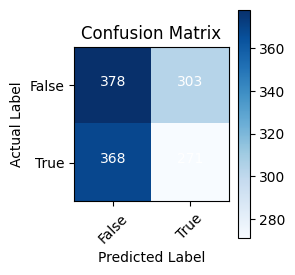

              precision    recall  f1-score   support

         0.0       0.51      0.56      0.53       681
         1.0       0.47      0.42      0.45       639

    accuracy                           0.49      1320
   macro avg       0.49      0.49      0.49      1320
weighted avg       0.49      0.49      0.49      1320



In [135]:
# draw_confusion_matrix(clf_lr_1, x_test, y_test, 'logistic_regression_sklearn')
draw_confusion_matrix(clf_lr_2, x_test, y_test, 'logistic_regression_numpy')

2. ROC Curve

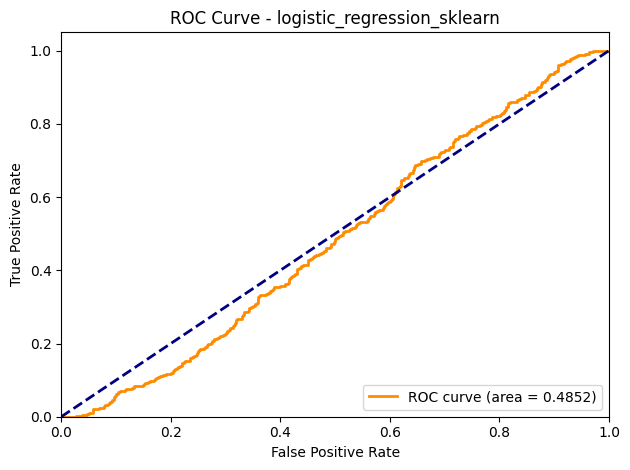

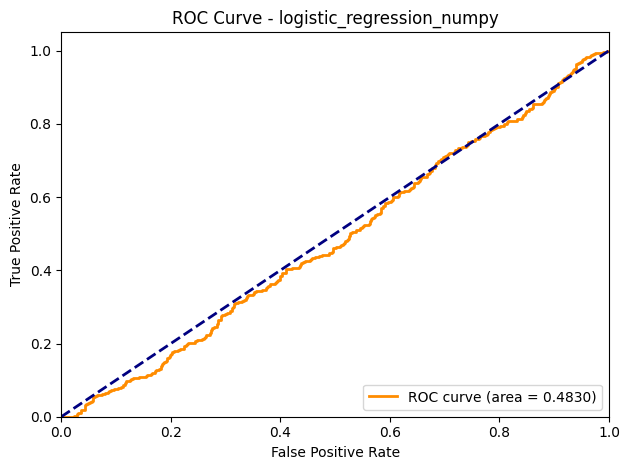

In [120]:
# draw_roc(clf_lr_1, x_test, y_test, 'logistic_regression_sklearn')
draw_roc(clf_lr_2, x_test, y_test, 'logistic_regression_numpy')

In [109]:
print(type(clf_lr_2))

<class '__main__.LogisticRegression'>


In [ ]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

print("F1 Score (sklearn):", f1)

3. Epoch에 따른 학습 과정중 손실(loss)그래프

In [ ]:
plt.figure()
plt.plot(history_lr)
plt.title('Training Loss')
plt.ylabel('loss', fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.tight_layout()
plt.savefig('lr_learning_curve.png', dpi=100, bbox_inches='tight')
plt.show()